### Edgar Moises Hernandez-Gonzalez
#### 10/04/20
#### Clasificacion de imagenes motoras en EEG con CNN-2D
##### Caracteristicas = Espectrogramas STFFT (3D)
##### Concatenacion vertical
##### 5 ejecuciones independientes

#### CNN-2D
##### Sujeto 1
##### Accuracy = 68.40%
##### Kappa = 0.5787

In [0]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from scipy.signal import spectrogram
import cv2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPool2D, Flatten, Dense, Dropout,
                                     BatchNormalization, Activation)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

In [2]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [0]:
x_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01T.csv", header=None)
x_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01E.csv", header=None)
y_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA01T.csv", header=None)
y_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA01E.csv", header=None)

In [4]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(288, 22000)
(288, 22000)
(288, 1)
(288, 1)


In [5]:
n_samples_train = len(y_train)
n_samples_test = len(y_test) #en caso de no tener el y_test se puede utilizar el x_test

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 288
n_samples_test : 288


In [6]:
n_classes = len(np.unique(y_test)) #esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test

print("n_classes:", n_classes)

n_classes: 4


In [7]:
#codificar etiquetas con valores de 0 a nClases-1
le = LabelEncoder().fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
# las etiquetas en categorical para poder entrenar data augmentation
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

In [0]:
#unir 22 canales y resize de tamaño proporcional
def unir_espectrogramas_vertical_resize(data):
  dim = (8, 264) #ancho, alto
  fs = 250
  datos = np.zeros((288,264,8))
  temporal = np.zeros((528,4))
  for i in range(data.shape[0]): #288 muestras
    for j in range(22): #22 canales
      sig = data.iloc[i, j*1000:(j+1)*1000]
      f, t, Sxx = spectrogram(sig, fs) #espectrograma de STFFT
      temporal[j*24:(j+1)*24, :] = Sxx[8:32, :]
    resized = cv2.resize(temporal, dim, interpolation=cv2.INTER_AREA)
    datos[i] = resized
  return datos

In [0]:
#llamar a unir_espectrogramas_vertical_resize(data)
x_train = unir_espectrogramas_vertical_resize(x_train)
x_test = unir_espectrogramas_vertical_resize(x_test)

In [11]:
print(x_train.shape)
print(x_test.shape)

(288, 264, 8)
(288, 264, 8)


In [12]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

65.53692251223107
55.06980719402351
0.001085261144493673
0.00041804610564340585
1.1717788228684476
1.1858305338371293


In [0]:
#convertir a float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#escalar los valores en un rango de 0 a 1 (normalizar)
x_train /= 66.0
x_test /= 66.0

In [14]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

0.99298376
0.83439106
1.644335e-05
6.334032e-06
0.017754223
0.017967127


In [15]:
#convertir de 3D a 4D
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))

print(x_train.shape)
print(x_test.shape)

(288, 264, 8, 1)
(288, 264, 8, 1)


In [0]:
datagen_train = ImageDataGenerator(width_shift_range=0.25)

In [0]:
def CNN_2D():
  model = Sequential()
  model.add(Conv2D(16, (3,3), activation='relu', padding='same',
                   input_shape=x_train.shape[1:]))
  model.add(MaxPool2D((2,2)))
  model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
  model.add(MaxPool2D((2,2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
  return model

Iteration: 1
Instructions for updating:
Please use Model.fit, which supports generators.
9/9 - 0s - loss: 1.2775 - accuracy: 0.6562
kappa:  0.5416666666666667
confusion matrix:
 [[55 11  4  2]
 [17 44  9  2]
 [ 6  0 35 31]
 [ 3  1 13 55]]


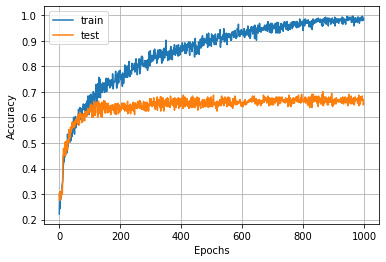

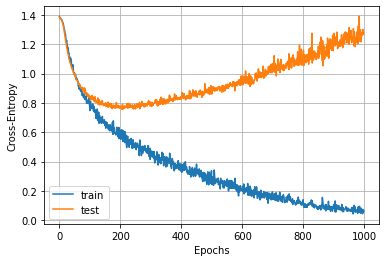

Iteration: 2
9/9 - 0s - loss: 1.4142 - accuracy: 0.6632
kappa:  0.5509259259259259
confusion matrix:
 [[58  7  5  2]
 [24 40  7  1]
 [ 4  1 41 26]
 [ 6  1 13 52]]


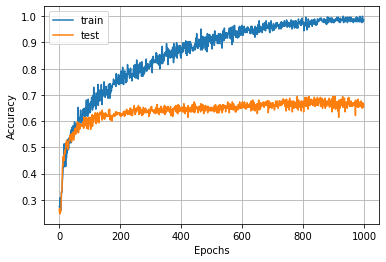

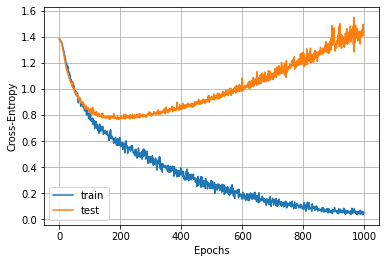

Iteration: 3
9/9 - 0s - loss: 1.4948 - accuracy: 0.6389
kappa:  0.5185185185185186
confusion matrix:
 [[52 11  6  3]
 [23 38  9  2]
 [ 3  0 35 34]
 [ 2  1 10 59]]


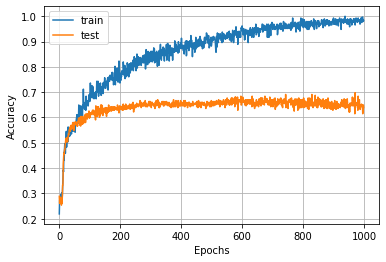

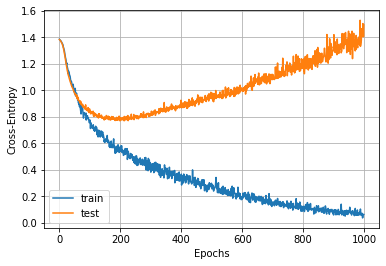

Iteration: 4
9/9 - 0s - loss: 1.4252 - accuracy: 0.6667
kappa:  0.5555555555555556
confusion matrix:
 [[53 10  6  3]
 [15 46  9  2]
 [ 4  0 39 29]
 [ 4  1 13 54]]


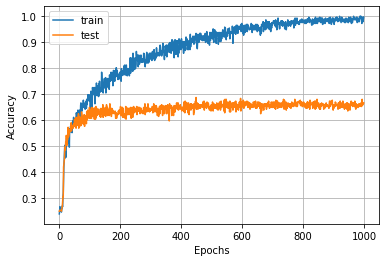

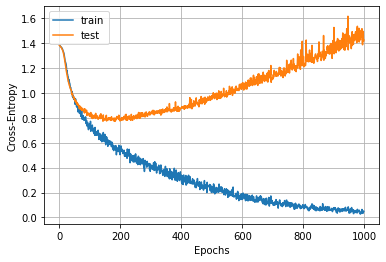

Iteration: 5
9/9 - 0s - loss: 1.2905 - accuracy: 0.6840
kappa:  0.5787037037037037
confusion matrix:
 [[44 17  8  3]
 [ 8 53  9  2]
 [ 3  0 45 24]
 [ 2  1 14 55]]


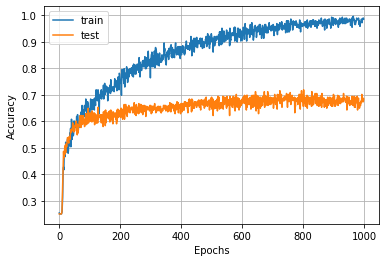

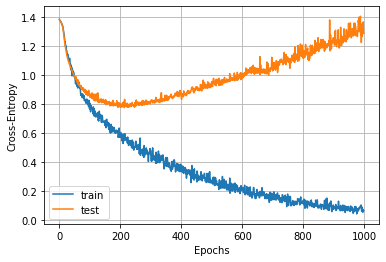


Resultados:
loss: [1.277466893196106, 1.414201259613037, 1.4948015213012695, 1.4252276420593262, 1.2904800176620483]
accuracy: [0.65625, 0.6631944179534912, 0.6388888955116272, 0.6666666865348816, 0.6840277910232544]
kappa: [0.5416666666666667, 0.5509259259259259, 0.5185185185185186, 0.5555555555555556, 0.5787037037037037]


In [18]:
array_loss = []
array_acc = []
array_kappa = []
for i in range(5):
  print("Iteration:", i+1)
    
  model = CNN_2D()

  history = model.fit_generator(datagen_train.flow(x_train, y_train_categorical, batch_size=18),
                                steps_per_epoch=np.ceil(n_samples_train/18),
                                epochs=1000,
                                validation_data=(x_test, y_test_categorical),
                                verbose=0)

  test_loss, test_acc = model.evaluate(x_test, y_test_categorical, verbose=2)
  array_loss.append(test_loss)
  array_acc.append(test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa)
  print("kappa: ", kappa)
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)
    
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
    
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)

In [19]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 264, 8, 16)        160       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 132, 4, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 132, 4, 16)        2320      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 66, 2, 16)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2112)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               270464    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)              

In [20]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))

Mean Accuracy: 0.6618
std: (+/- 0.0147)
Mean Kappa: 0.5491
std: (+/- 0.0196)
Max Accuracy: 0.6840
Max Kappa: 0.5787
